# 9장 시계열을위한 머신러닝 (클러스터링)

> cesium 등을 다룬다.
- author: "Chansung Park"
- toc: false
- comments: false
- categories: [machine learning, clustering, unsupervised learning]
- permalink: /chapter9-clustering/
- badges: true
- hide_github_badge: true

* 시계열 자체를 입력으로 사용하려면, 동적시간워핑(Dynamic Time Warping; DTW)라는 거리 평가 지표를 알아야 한다. 시계열에 직접적으로 적용되는 DTW는 데이터 전체에 대한 시간 정보를 보존한다. 

1. 특징에 기반한 거리
  - 시계열을 위한 feature를 생성하고, 이들을 데이터의 계산을 위한 좌표로 취급한다
  - 비시계열과 데이터셋의 거리 측정과 동일한 수준의 문제로 만들 수 있다
2. raw 시계열 데이터에 기반한 거리
  - 서로 다른 시계열이 얼마나 '가까운지'를 결정하는 방법을 찾는다.
  - 가급적이면 서로 다른 시간의 규모, 서로 다른 측정 개수, 그 외 시계열 표본 사이의 있을 법한 불균형을 다룰 수 있는 방식이어야 한다.

In [ ]:
!pip install dtaidistance
!pip install cesium

     |████████████████████████████████| 942kB 6.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for dtaidistance: filename=dtaidistance-2.2.5-cp37-cp37m-linux_x86_64.whl size=1552466 sha256=66358913476fdb1b7e8b5525a2c5e8b564c4885ceee9ef441012a1b4f49e1ff3
  Stored in directory: /root/.cache/pip/wheels/f8/37/a3/5b68a20ca502772e5affea6be75bf964ad9f481fdc54f28627
Successfully built dtaidistance
     |████████████████████████████████| 225kB 6.6MB/s 
     |████████████████████████████████| 563kB 7.9MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-cp37-none-any.whl size=43807 sha256=4e358a50bd164442beb9987eba0c07ec3bbf9b3c57517b9f0e9f52302fc6272e
  Stored in directory: /root/.cache/pip/wheels/4f/8f/fa/0d7b250ef21828ca373b21f6b3b6ef0f2a0e3560b69c91e55d
Successfully built gatspy


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from math import sqrt

from datetime import datetime
import pandas as pd
import numpy as np
import pdb


from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import homogeneity_score, completeness_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import homogeneity_score

from dtaidistance import dtw

from collections import Counter

from scipy.stats import pearsonr

## The data

In [ ]:
words = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/50words_TEST.csv',
                    header = None)

In [ ]:
words.rename(columns = {0:'word'}, inplace = True) 

In [ ]:
words

,word,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270
0,4,-0.89094,-0.86099,-0.82438,-0.78214,-0.73573,-0.68691,-0.637540,-0.589370,-0.543420,-0.500440,-0.460820,-0.424690,-0.39240,-0.36389,-0.339060,-0.317950,-0.300560,-0.286920,-0.277270,-0.271050,-0.267770,-0.266780,-0.267420,-0.269270,-0.272020,-0.275290,-0.278980,-0.283200,-0.288140,-0.294310,-0.301850,-0.310860,-0.321350,-0.333260,-0.346500,-0.361030,-0.376590,-0.39297,-0.409950,...,0.052471,-0.01492,-0.082568,-0.14848,-0.21193,-0.27229,-0.32905,-0.38303,-0.432220,-0.476280,-0.515870,-0.55188,-0.58534,-0.61763,-0.64653,-0.67227,-0.69521,-0.71576,-0.735170,-0.752860,-0.76798,-0.78120,-0.79326,-0.80474,-0.81719,-0.82831,-0.837680,-0.845380,-0.85165,-0.85731,-0.86309,-0.86791,-0.87271,-0.87846,-0.88592,-0.89619,-0.90783,-0.91942,-0.93018,-0.93939
1,12,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.172250,-0.087463,-0.019191,0.035301,0.080601,0.121210,0.16167,0.20223,0.239730,0.273860,0.305240,0.334170,0.364750,0.399670,0.436950,0.474700,0.509190,0.534400,0.547550,0.549650,0.542360,0.529090,0.515230,0.503070,0.491830,0.482130,0.472450,0.459290,0.443090,0.424040,0.400530,0.37585,0.351890,...,0.711070,0.64773,0.579890,0.50674,0.42767,0.34155,0.24849,0.15221,0.056228,-0.036684,-0.123520,-0.20472,-0.28299,-0.35917,-0.43397,-0.50794,-0.57864,-0.64302,-0.700170,-0.749010,-0.78785,-0.81818,-0.84200,-0.85809,-0.86830,-0.87519,-0.877210,-0.876610,-0.87728,-0.87899,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.98050,-0.99178
2,13,-1.32560,-1.28430,-1.21970,-1.15670,-1.09980,-1.04960,-1.015500,-0.996720,-0.985040,-0.971990,-0.964030,-0.963550,-0.96236,-0.95077,-0.917330,-0.871050,-0.817930,-0.760640,-0.701060,-0.644150,-0.594710,-0.529310,-0.409210,-0.205990,0.066333,0.344810,0.565100,0.703590,0.785270,0.840450,0.870940,0.857640,0.775790,0.634510,0.480380,0.351620,0.241000,0.11593,-0.022140,...,-0.443510,-0.43741,-0.444480,-0.45708,-0.46691,-0.47419,-0.47495,-0.46916,-0.456730,-0.439730,-0.421350,-0.40614,-0.40352,-0.41293,-0.42965,-0.44611,-0.45623,-0.46585,-0.484310,-0.520100,-0.56853,-0.61788,-0.65943,-0.68651,-0.70204,-0.71318,-0.726460,-0.745680,-0.77144,-0.80390,-0.83499,-0.86204,-0.88559,-0.90454,-0.93353,-0.99135,-1.06910,-1.13680,-1.19800,-1.27000
3,23,-1.09370,-1.04200,-0.99840,-0.95997,-0.93997,-0.93764,-0.926490,-0.857090,-0.693320,-0.312890,0.339420,0.989090,1.33000,1.34950,1.222900,1.044500,0.829670,0.602100,0.365250,0.128330,-0.046387,-0.165640,-0.265030,-0.362500,-0.449520,-0.510830,-0.562550,-0.608530,-0.635880,-0.632320,-0.597000,-0.520320,-0.427310,-0.291990,-0.066752,0.241280,0.610500,0.96181,1.211600,...,1.115600,1.76630,2.558000,3.33430,3.84940,3.90180,3.62190,3.18950,2.623000,2.031000,1.497900,1.00600,0.55445,0.16993,-0.12355,-0.31586,-0.43344,-0.50570,-0.532680,-0.536880,-0.54374,-0.56792,-0.60857,-0.63638,-0.64471,-0.64440,-0.653820,-0.669570,-0.69135,-0.71082,-0.72810,-0.74512,-0.76376,-0.78068,-0.80593,-0.84350,-0.89531,-0.96052,-1.05090,-1.12830
4,4,-0.90138,-0.85228,-0.80196,-0.74932,-0.69298,-0.63316,-0.570380,-0.506920,-0.446040,-0.390180,-0.339310,-0.292310,-0.24833,-0.20635,-0.165850,-0.127190,-0.091931,-0.059946,-0.030921,-0.004628,0.018364,0.038239,0.054732,0.067206,0.075442,0.080507,0.083344,0.083628,0.081179,0.075684,0.066456,0.051670,0.032078,0.008739,-0.017323,-0.046021,-0.075800,-0.10581,-0.136220,...,-0.394410,-0.37672,-0.357160,-0.33905,-0.32255,-0.30807,-0.29818,-0.29607,-0.300260,-0.310800,-0.328090,-0.35262,-0.38035,-0.41034,-0.44236,-0.47573,-0.50864,-0.54145,-0.575060,-0.608890,-0.64237,-0.67593,-0.71042,-0.74502,-0.77959,-0.81402,-0.848050,-0.879590,-0.90785,-0.93276,-0.95452,-0.97322,-0.98984,-1.00520,-1.01880,-1.02960,-1.03700,-1.04110,-1.04180,-1.04030
...,...,...,...,...,...,.

## View output

In [ ]:
words.word[1]

12

Text(0.5, 0.98, 'Sample word projections and histograms of the projections')

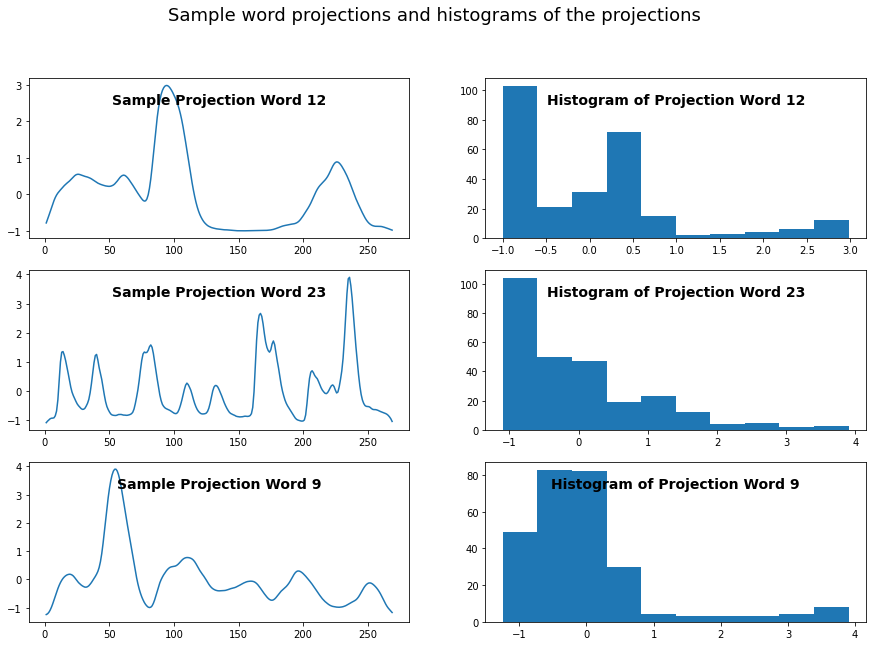

In [ ]:
plt.subplot(3, 2, 1)
plt.plot(words.iloc[1, 1:-1])
plt.title("Sample Projection Word " + str(words.word[1]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 2)
plt.hist(words.iloc[1, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[1]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 3)
plt.plot(words.iloc[3, 1:-1])
plt.title("Sample Projection Word " + str(words.word[3]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 4)
plt.hist(words.iloc[3, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[3]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 5)
plt.plot(words.iloc[5, 1:-1])
plt.title("Sample Projection Word " + str(words.word[11]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 6)
plt.hist(words.iloc[5, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[11]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.suptitle("Sample word projections and histograms of the projections", fontsize = 18)

## **hist2d : 각 시간마다 histogram을 그렸다고 생각하면 된다. 다른 시계열 데이터 분석에서도 유용할 것!!! 또한 시간에 따른 linegraph를 중첩해서 그렸다고 생각하면 된다!!**

## 여러 개의 시간-value 그래프를 중첩해서 그린 것!!

Text(0, 0.5, 'Value')

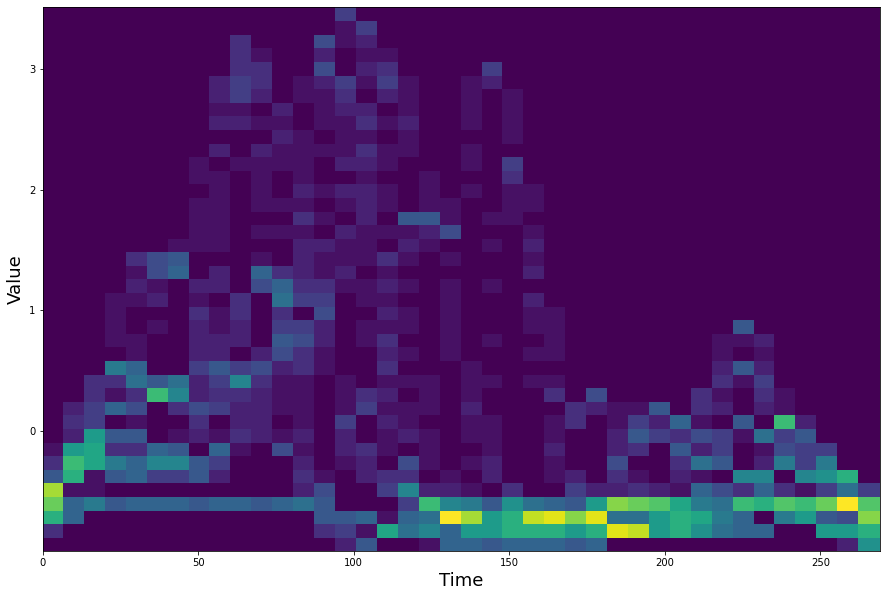

In [ ]:

## We can also consider the 2d histogram of a word
x = np.array([])
y = np.array([])

w = 12
selected_words = words[words.word == w]
selected_words.shape

for idx, row in selected_words.iterrows():
    y = np.hstack([y, row[1:271]])
    x = np.hstack([x, np.array(range(270))])
    
fig, ax = plt.subplots()
hist = ax.hist2d(x, y, bins = 40)
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Value", fontsize = 18)

* 1d 히스토그램 : 고점을 찾을 수 있다. 
  - ex) 고점의 개수, 뒤틀림, 첨도 등. 즉, 시간에 상관없이 value 그 자체의 개수나 이런 것을 알 수 있다.
* 2d 히스토그램 : 시간축을 반영한 정보 확인할 수 있다. 
  - ex) 두 고점 사이에 평평함을 공통으로 가진다 (120~200번째 시간 단계의 색을 보면)
  - **50-150 시각에서 최고점이 나온다.최댓값이 50~150 시간 단계 사이에 도달했는지? 와 같은 feature를 만들 수 있을 것이다.**

In [ ]:
selected_words

,word,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270
1,12,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.17225,-0.087463,-0.019191,0.035301,0.080601,0.12121,0.16167,0.20223,0.239730,0.273860,0.305240,0.33417,0.364750,0.399670,0.436950,0.474700,0.509190,0.534400,0.54755,0.549650,0.542360,0.529090,0.515230,0.503070,0.491830,0.48213,0.47245,0.45929,0.44309,0.42404,0.40053,0.37585,0.35189,...,0.711070,0.647730,0.579890,0.506740,0.427670,0.341550,0.248490,0.152210,0.056228,-0.036684,-0.123520,-0.204720,-0.282990,-0.359170,-0.433970,-0.507940,-0.578640,-0.64302,-0.70017,-0.74901,-0.78785,-0.81818,-0.84200,-0.85809,-0.86830,-0.87519,-0.87721,-0.87661,-0.87728,-0.87899,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.98050,-0.99178
55,12,-0.65904,-0.62525,-0.58935,-0.54896,-0.50556,-0.46049,-0.41860,-0.385650,-0.359560,-0.338580,-0.322480,-0.30840,-0.29826,-0.29244,-0.286430,-0.280400,-0.273060,-0.26323,-0.256180,-0.251520,-0.248130,-0.248420,-0.248460,-0.244590,-0.23437,-0.209560,-0.164040,-0.094924,0.001522,0.123680,0.267220,0.42740,0.59400,0.75686,0.90731,1.03640,1.14280,1.22850,1.29440,...,-0.596280,-0.535420,-0.466510,-0.396300,-0.331980,-0.278860,-0.240040,-0.216740,-0.208350,-0.212990,-0.227700,-0.248870,-0.272980,-0.297360,-0.320460,-0.341570,-0.360450,-0.37710,-0.39184,-0.40539,-0.41873,-0.43267,-0.44748,-0.46287,-0.47831,-0.49349,-0.50862,-0.52425,-0.54076,-0.55814,-0.57579,-0.59332,-0.61147,-0.63093,-0.65236,-0.67554,-0.69730,-0.71463,-0.72615,-0.73123
147,12,-0.71717,-0.68091,-0.63841,-0.58892,-0.53264,-0.47139,-0.40747,-0.344300,-0.286010,-0.234900,-0.191560,-0.15565,-0.12682,-0.10352,-0.084548,-0.069375,-0.057266,-0.04693,-0.037601,-0.030110,-0.024582,-0.021632,-0.022047,-0.026295,-0.03320,-0.041518,-0.051102,-0.061371,-0.071801,-0.082305,-0.093497,-0.10396,-0.11262,-0.11996,-0.12681,-0.13336,-0.14024,-0.14992,-0.16102,...,-0.784830,-0.783840,-0.782730,-0.781010,-0.778050,-0.773490,-0.767330,-0.759800,-0.751020,-0.740750,-0.728290,-0.712870,-0.694050,-0.672090,-0.648140,-0.623910,-0.601340,-0.58208,-0.56733,-0.55774,-0.55349,-0.55441,-0.56002,-0.56960,-0.58217,-0.59674,-0.61236,-0.62830,-0.64411,-0.65961,-0.67476,-0.68960,-0.70420,-0.71863,-0.73292,-0.74692,-0.76027,-0.77238,-0.78246,-0.78987
222,12,-0.53903,-0.53955,-0.55822,-0.57715,-0.58502,-0.58534,-0.58722,-0.593270,-0.599030,-0.600760,-0.599830,-0.59923,-0.59935,-0.59871,-0.597190,-0.596470,-0.597580,-0.59959,-0.601060,-0.601560,-0.601680,-0.601870,-0.602140,-0.602580,-0.60331,-0.604060,-0.603930,-0.602670,-0.600810,-0.599260,-0.598290,-0.59718,-0.59534,-0.59307,-0.59137,-0.59080,-0.59081,-0.59048,-0.58941,...,-0.538140,-0.481500,-0.398790,-0.295750,-0.184640,-0.080971,0.003016,0.059882,0.088580,0.093776,0.083362,0.065894,0.046004,0.023565,-0.004355,-0.039651,-0.080948,-0.12445,-0.16618,-0.20356,-0.23554,-0.26209,-0.28396,-0.30240,-0.31882,-0.33409,-0.34848,-0.36135,-0.37216,-0.38132,-0.38973,-0.40127,-0.41837,-0.44366,-0.47650,-0.51240,-0.54696,-0.57395,-0.59174,-0.60066
294,12,-0.77367,-0.71285,-0.64288,-0.57090,-0.50449,-0.44685,-0.39856,-0.359380,-0.326620,-0.298220,-0.273660,-0.25145,-0.23117,-0.21394,-0.200010,-0.190320,-0.185980,-0.18589,-0.188720,-0.193360,-0.197890,-0.201860,-0.206020,-0.210410,-0.21583,-0.222780,-0.230170,-0.237380,-0.243710,-0.247940,-0.250790,-0.25284,-0.25385,-0.25559,-0.25779,-0.25931,-0.26309,-0.26884,-0.27536,...,0.406400,0.362000,0.314850,0.263510,0.207300,0.145950,0.080034,0.012174,-0.054457,-0.116750,-0.171800,-0.218160,-0.255710,-0.285430,-0.308940,-0.326750,-0.339060,-0.34738,-0.35258,-0.35647,-0.36159,-0.36660,-0.37039,-0.37437,-0.37829,-0.38335,-0.39088,-0.39758,-0.40341,-0.41378,-0.43335,-0.46619,-0.51009,-0.55327,-0.58751,-0.61489,-0.64465,-0.68912,-0.75058,-0.81450
2

Text(0, 0.5, 'Value')

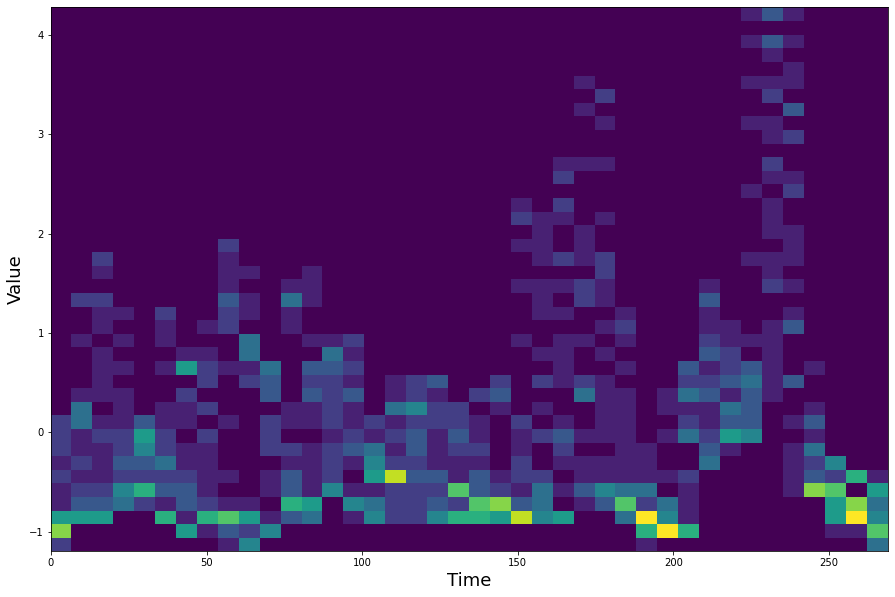

In [ ]:

## We can also consider the 2d histogram of a word
x = np.array([])
y = np.array([])

w = 23
selected_words = words[words.word == w]
selected_words.shape

for idx, row in selected_words.iterrows():
    y = np.hstack([y, row[1:271]])
    x = np.hstack([x, np.array(range(270))])
    
fig, ax = plt.subplots()
hist = ax.hist2d(x, y, bins = 40)
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Value", fontsize = 18)

*  혹(띄엄띄엄 색깔이 칠해져 있음)이 많이 보인다. 23 단어의 1d line graph를 보면 울퉁불퉁한 것을 보면 이해 가능하다. 
  - 샘플 간에 특징이 정확히 일치하지 않기 때문
* 150 시각 이후에 최고점 등장

## Generate some features

In [ ]:
words.shape

(455, 271)

In [ ]:
words_features = words.iloc[:, 1:271]

### Create some features from original time series

In [ ]:
times  = []
values = []
for idx, row in words_features.iterrows():
    values.append(row.values)
    times.append(np.array([i for i in range(row.values.shape[0])]))

In [ ]:
len(values)

455

In [ ]:
from cesium import featurize

features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "percent_close_to_median",
                   ]
featurized_words = featurize.featurize_time_series(times=times,
                                              values=values,
                                              errors=None,
                                              features_to_use=features_to_use,
                                              scheduler = None)
featurized_words.to_csv('./featurized_words.csv')

In [ ]:
featurized_words = pd.read_csv("./featurized_words.csv", header =  [0, 1])
featurized_words.columns = featurized_words.columns.droplevel(-1)

In [ ]:
featurized_words.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median
0,0,1.674555,0.188889,0.451852
1,1,1.990520,0.118519,0.259259
2,2,2.903650,0.114815,0.637037
3,3,2.515050,0.211111,0.562963
4,4,1.966150,0.181481,0.533333


In [ ]:
featurized_words.shape

(455, 4)

(array([ 48., 146., 100.,  45.,  41.,  29.,  23.,  12.,   8.,   3.]),
 array([0.05925926, 0.10666667, 0.15407407, 0.20148148, 0.24888889,
        0.2962963 , 0.3437037 , 0.39111111, 0.43851852, 0.48592593,
        0.53333333]),
 <a list of 10 Patch objects>)

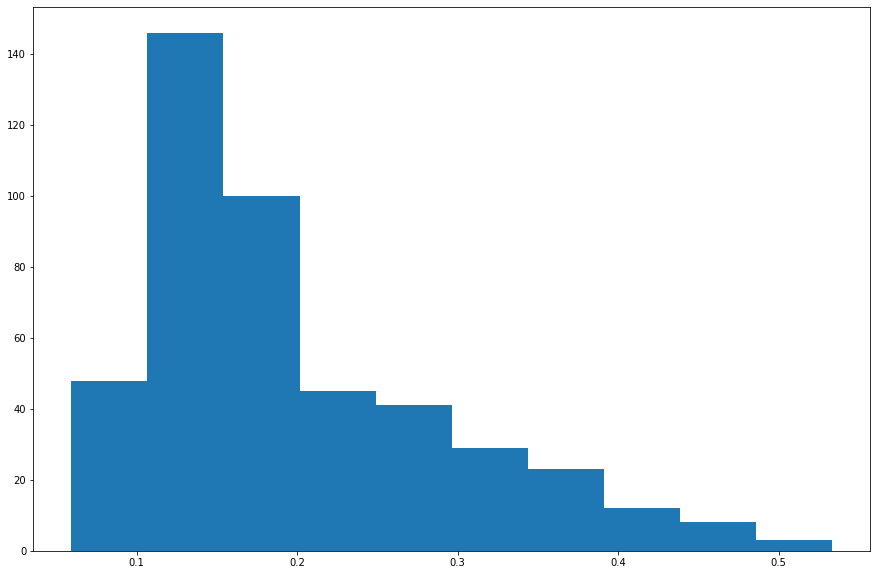

In [ ]:
plt.hist(featurized_words.percent_beyond_1_std)

### Create some features from histogram

In [ ]:
times = []
values = []
for idx, row in words_features.iterrows():
    values.append(np.histogram(row.values, bins=10, range=(-2.5, 5.0))[0] + .0001) ## cesium seems not to handle 0s
    times.append(np.array([i for i in range(9)]))

In [ ]:
features_to_use = ["amplitude",
                   "percent_close_to_median",
                  "skew"
                  ]
featurized_hists = featurize.featurize_time_series(times=times,
                                              values=values,
                                              errors=None,
                                              features_to_use=features_to_use,
                                              scheduler = None)
featurized_hists.to_csv('./featurized_hists.csv')

In [ ]:
featurized_hists = pd.read_csv("./featurized_hists.csv", header = [0, 1])
featurized_hists.columns = featurized_hists.columns.droplevel(-1)

In [ ]:
featurized_hists.head()

,feature,amplitude,percent_close_to_median,skew
0,0,88.0,0.444444,2.262655
1,1,61.0,0.666667,1.285343
2,2,70.0,0.666667,1.683031
3,3,67.0,0.555556,1.724109
4,4,75.0,0.777778,1.902513


In [ ]:
features = pd.concat([featurized_words.reset_index(drop=True), featurized_hists], axis=1)

In [ ]:
features.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,feature,amplitude,percent_close_to_median,skew
0,0,1.674555,0.188889,0.451852,0,88.0,0.444444,2.262655
1,1,1.990520,0.118519,0.259259,1,61.0,0.666667,1.285343
2,2,2.903650,0.114815,0.637037,2,70.0,0.666667,1.683031
3,3,2.515050,0.211111,0.562963,3,67.0,0.555556,1.724109
4,4,1.966150,0.181481,0.533333,4,75.0,0.777778,1.902513


In [ ]:
words.shape

(455, 271)

In [ ]:
## we also add some of our own features again, to account more for shape
feats = np.zeros( (words.shape[0], 1), dtype = np.float32)
for i in range(words.shape[0]):
    vals = words.iloc[i, 1:271].values
    feats[i, 0] = np.where(vals == np.max(vals))[0][0]

In [ ]:
feats.shape

(455, 1)

In [ ]:
features.shape

(455, 8)

In [ ]:
features['peak_location'] = feats

In [ ]:
features.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,feature,amplitude,percent_close_to_median,skew,peak_location
0,0,1.674555,0.188889,0.451852,0,88.0,0.444444,2.262655,186.0
1,1,1.990520,0.118519,0.259259,1,61.0,0.666667,1.285343,93.0
2,2,2.903650,0.114815,0.637037,2,70.0,0.666667,1.683031,69.0
3,3,2.515050,0.211111,0.562963,3,67.0,0.555556,1.724109,235.0
4,4,1.966150,0.181481,0.533333,4,75.0,0.777778,1.902513,174.0


In [ ]:
feature_values = preprocessing.scale(features.iloc[:, [1, 2, 3, 5, 6, 7]])

In [ ]:
clustering = AgglomerativeClustering(n_clusters=50, linkage='ward')
clustering.fit(feature_values)
words['feature_label'] = clustering.labels_

In [ ]:
words['feature_label'] = words.feature_label.astype('category')

In [ ]:
## the number of feature labels 
results = words.groupby('word')['feature_label'].agg(num_clustering_labels=lambda x: len(set(x)),
                                                    num_word_samples=lambda x: len(x),
                                                    most_common_label=lambda x: Counter(x).most_common(1)[0][0])
results.head()

,num_clustering_labels,num_word_samples,most_common_label
word,,,
1,19,57,38
2,19,42,29
3,16,28,37
4,17,34,17
5,13,25,8


In [ ]:
## the number of feature labels 
results_feats = words.groupby('feature_label')['word'].agg(num_words=lambda x: len(set(x)),
                                                           num_feat_samples=lambda x: len(x),
                                                           most_common_word=lambda x: Counter(x).most_common(1)[0][0])
results_feats
## note that word 1 = most common in cluster 38

,num_words,num_feat_samples,most_common_word
feature_label,,,
0,9,16,2
1,5,5,13
2,7,8,16
3,8,9,1
4,10,20,1
5,4,8,2
6,5,6,15
7,6,6,7
8,6,17,5


In [ ]:
homogeneity_score(words.word, words.feature_label)
## see definitions in user manual: https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness

0.5085776345414814

In [ ]:
from sklearn import preprocessing
feature_values = preprocessing.scale(features.values)

In [ ]:
## Agglomerative clustering : 병합 군집

from sklearn.cluster import AgglomerativeClustering
feature_clustering = AgglomerativeClustering(n_clusters = 50,
                                             linkage = 'ward')
feature_clustering.fit(feature_values)
words['feature_labels']=feature_clustering.fit_predict(feature_values)

In [ ]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(words.word, words.feature_labels)

0.533391542031503

# 개선 방법

* feature 더 추가해서 개선 가능할 것
* **여전히 유용한 feature 놓치고 있음. 시각적 데이터 탐색을 통해 눈에 띄는 고점의 개수와 위치 같은 몇 가지 특징을 발견할 수 있었다. 이 분석을 재작업하여 해당 정보나 특징을 찾아야 함**
* 다른 거리 지표를 사용해서 사람의 눈으로 유용하다고 판단한 것 중 다른 특징보다 더 무게를 줄 만한 것들을 찾아봐야 함

## Dynamic Time Warping Distance Definition

# DTW

[https://www.youtube.com/watch?v=03J4xzymOWM : 아래 해당 동영상 요약한 것] 

* DTW : 동일한 시간선 상의 데이터 뿐 아니라 주변 요소까지 비교 쌍으로 사용하여 정확도를 높인다.

* 장점
  - 서로 다른 길이의 시계열도 유사도 분석 가능
  - GPS 데이터 등 다차원 시계열 데이터의 분석 가능

* 단점
  - 알고리즘 구현이 어렵고 **연산량이 많음ㅠㅠ**
  - 효율적으로 검색하기 위한 다양한 아이디어로 DTW를 구현한 여러가지 사례가 있다. 특히 대규모 데이터셋으로 작업하는 경우, 성능의 요구 사항에 맞는 여러 가지 구현체에 대한 정보를 탐색해보는 것이 좋다.

* 방법론 : DTW는 적절한 index를 매칭시켜주어서 distance를 계산하는 것이다.

* 한계점 : 과도한 왜곡 warping
  - 왜곡 정도에 아무런 제약을 주지 않을 경우에는 너무 과도하게 만들어서 오히려 유사하지 않은 시계열들을 유사한 것 처럼 비교할 가능성이 있음
  - Constrainted_DTW : 어느정도 왜곡할 수 있는 범위를 제약하는 알고리즘


* [좋은 자료]
  - https://hamait.tistory.com/862
  - https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd


# Frechet distance

[Paper : 이산 프례셰 거리 척도를 이용한 궤적 유사도 고속계산 휴리스틱 알고리즘]
* 두 궤적의 진행 방향이나 모양을 고려하여 계산 --> 값이 작을수록 두 궤적은 가깝고 모양도 비슷하다
* 개와 사람의 산책을 예로 쉽게 설명된다
  - 목줄을 묶은 개와 사람이 각자 궤적을 따라 시작 지점부터 끝 지점까지 산책을 한다.
  - 각자의 속도는 조절할 수 있으나 뒤로 돌아갈 수는 없다.
  - 이 때 이 산책을 가능하게 하는 목줄의 최소 길이가 Frechet 거리가 된다. 
* 좋은 자료
  - https://medium.com/tblx-insider/how-long-should-your-dog-leash-be-ba5a4e6891fc
  - https://towardsdatascience.com/fast-discrete-fr%C3%A9chet-distance-d6b422a8fb77

# Pearson correlation
* 계산은 비교적 쉽지만, 이 방법을 사용하려면 두 시계열이 같은 수의 데이터로 구성되어야 한다.
  - 그렇지 않다면, 다운 샘플링해서 나머지 하나에 맞춰야 한다.
* 상관관계 계산의 시간 복잡도는 O(n)이므로 계산 자원의 관점에서 볼 때 효율적인 지표다.

# Longest common subsequence
* 범주형 값을 나타내는 시계열에 적합한 거리 측정
* 두 시계열에서 나타나는, 같은 값들의 최장 연속 길이를 의미한다.
  - 다만 그 값들이 정확히 같은 시간의 위치에 등장할 필요는 없다.
  - 값이 클수록 더 비슷한 시계열이라는 의미이다.
* DTW와 마찬가지로 공통된 모양이 발생하는 시간상의 위치보다 전체적인 공통된 모양을 찾는 데 더 관심이 있다.
* 두 시계열의 길이가 같은 필요는 없다. 
* 좋은 자료
  - https://twinw.tistory.com/126
  - https://mygumi.tistory.com/126
  - https://velog.io/@emplam27/%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98-%EA%B7%B8%EB%A6%BC%EC%9C%BC%EB%A1%9C-%EC%95%8C%EC%95%84%EB%B3%B4%EB%8A%94-LCS-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98-Longest-Common-Substring%EC%99%80-Longest-Common-Subsequence

# 상상력이 필요한 경우, 다시 말하면 데이터 변환 후 거리 측정
* https://stackoverflow.com/questions/48497756/time-series-distance-metric
* 이 사실은 raw data가 필요조건을 충족하지 않더라도, 시계열 변환으로 ARIMA 모델에 적절하도록 만들어줄 수 있다고 했던 이전의 분석 내용을 다시 한번 상기시켜준다. 

# 거리 지표의 선택, Clustering 알고리즘의 선택
* 다음의 균형을 찾는 최선의 판단을 내려야 함
  - 계산 자원 사용의 최소화
  - 최종 목표와 가장 관련 있는 시계열의 특징을 강조하는 지표를 선택한다.
  - **거리 지표가, 사용한 분석 방법의 가정, 강점 및 약점을 반영하는지 확인해야 한다. 예를 들어, k-means clustering은 pairwise-distance의 사용 대신 분산을 최소화하므로, 이 기법에는 유클리드와 비슷한 거리만 적절하다.**

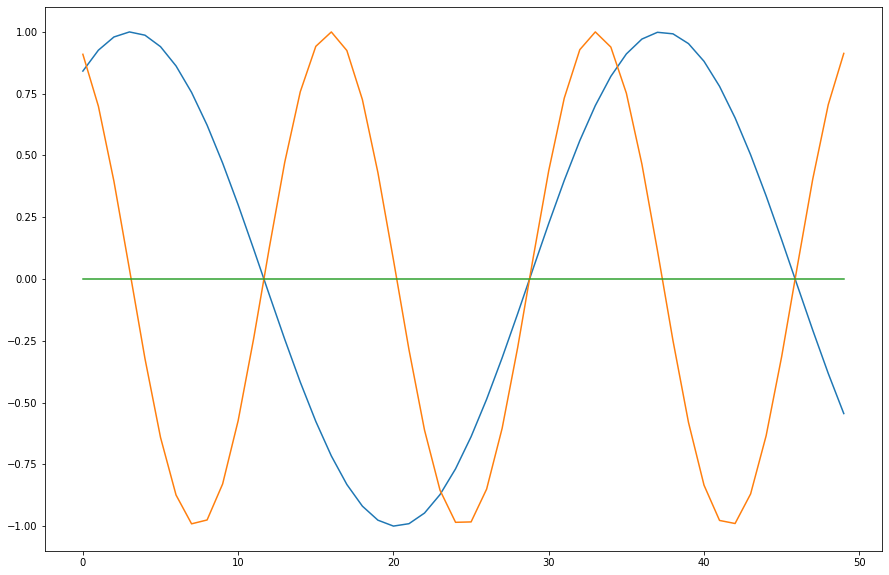

In [ ]:
ts1 = np.sin(np.linspace(1, 10))
ts2 = np.sin(2 * np.linspace(1, 10))
ts3 = np.zeros((50,)) 
plt.plot(ts1)
plt.plot(ts2)
plt.plot(ts3)

## Exercise: calculate the Euclidean distance between respective pairs of time series from the 3 time series above

In [ ]:
np.sqrt(np.sum(np.square(ts1 - ts2)))

7.3897194681883756

In [ ]:
np.sqrt(np.sum(np.square(ts1 - ts3)))

4.999710697636168

In [ ]:
np.sqrt(np.sum(np.square(ts2 - ts3)))

4.935018175874873

In [ ]:
np.linspace(1,10).shape

(50,)

## Another time series clustering technique that has been recommended is a correlation measure. How does this fair in the case of our sine curves and straigh line?

In [ ]:
np.random.seed(215202)
ts3_noise = np.random.random(ts3.shape)
ts3 = np.zeros((50,)) 
ts3 = ts3 + ts3_noise

In [ ]:
pearsonr(ts1, ts2)

(-0.10087714894729656, 0.485772279067736)

In [ ]:
pearsonr(ts1, ts3)

(0.19217749375608117, 0.1812125015007657)

In [ ]:
pearsonr(ts2, ts3 + np.random.random(ts3.shape))

(0.18666336432272013, 0.19429849424053683)

## Exercise: use what we discussed about dynamic programming to code a DTW function

In [ ]:
X = words.iloc[:, 1:271].values

In [ ]:
def distDTW(ts1, ts2):
    DTW       = np.full((len(ts1) + 1, len(ts2) + 1), 0, dtype = np.float32)
    DTW[:, 0] = np.inf
    DTW[0, :] = np.inf
    DTW[0, 0] = 0

    for i in range(1, len(ts1) + 1):
        for j in range(1, len(ts2) + 1):
            idx1 = i - 1 
            idx2 = j - 1
            
            dist               = (ts1[idx1] - ts2[idx2])**2
            min_preceding_dist = min(DTW[i-1, j],DTW[i, j-1], DTW[i-1, j-1])

            DTW[i, j] = dist + min_preceding_dist

    return sqrt(DTW[len(ts1), len(ts2)])

## Exercise: does this fix the problem above noted with the sine curves vs. a straight line?

In [ ]:
distDTW(ts1, ts2)

3.7609101849567645

In [ ]:
distDTW(ts1, ts3)

3.718500850249092

In [ ]:
distDTW(ts2, ts3)

4.163253276127519

In [ ]:
distDTW(X[0], X[1])

7.777960024318239

In [ ]:
dtw.distance(X[0], X[1])
## worth checking out: https://github.com/wannesm/dtaidistance

7.777960164340302

In [ ]:
p = pairwise_distances(X, metric = distDTW)

In [ ]:
with open("pairwise_word_distances.npy", "wb") as f:
    np.save(f, p)

In [ ]:
p = np.load("pairwise_word_distances.npy")

## Exercise: Try clustering based on dynamic time warping distances

In [ ]:
## We will use hierarchical clustering as a distance agnostic methodology

In [ ]:
clustering = AgglomerativeClustering(linkage='average', n_clusters=50, affinity = 'precomputed') 
## 'average' linkage is good for non Euclidean distance metrics

In [ ]:
labels = clustering.fit_predict(p)

In [ ]:
len(words.word)

In [ ]:
len(labels)

## Exercise: How did the clustering perform?

In [ ]:

print(homogeneity_score(words.word, labels))
print(completeness_score(words.word, labels))

In [ ]:
# quoting: https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness
# homogeneity: each cluster contains only members of a single class.
# completeness: all members of a given class are assigned to the same cluster.

In [ ]:
res = contingency_matrix(labels, words.word)

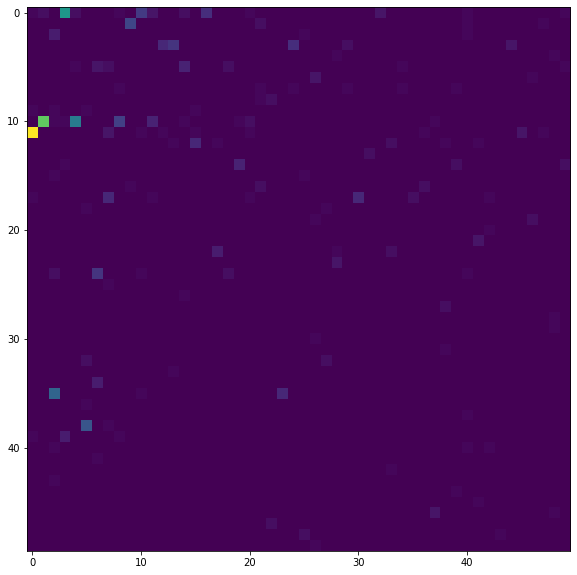

In [ ]:
## note difficulties in assessing this given imbalanced dataset
plt.imshow(res)

# 개선 방법
* DTW 거리와 특징을 모두 포함한다. DTW 거리와 특징을 결합하는 방식은 개념적으로나 코딩적으로나 까다롭다.
* 다른 거리 지표를 사용한다. 전에 언급한 대로 적절한 거리 지표란 데이터, 목표, 이어지는 분석 작업의 종류에 따라 달라진다. 따라서 이 단어 분석의 목표를 좀 더 좁고 기하학적으로 정의할 필요가 있다. 그러면 DTW가 목표에 대한 최상의 측정 기준을 판단해볼 수 있다. 